In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import seaborn as sns
import mapclassify as mc
import matplotlib.pyplot as plt


In [2]:
# dataset = pd.read_pickle('../../geodata/results/02_spatial_lagged_master.pkl')
dataset = pd.read_pickle('../../../geodata/results/02_spatial_lagged_master.pkl')

<Axes: xlabel='nabr_avg_slope', ylabel='Count'>

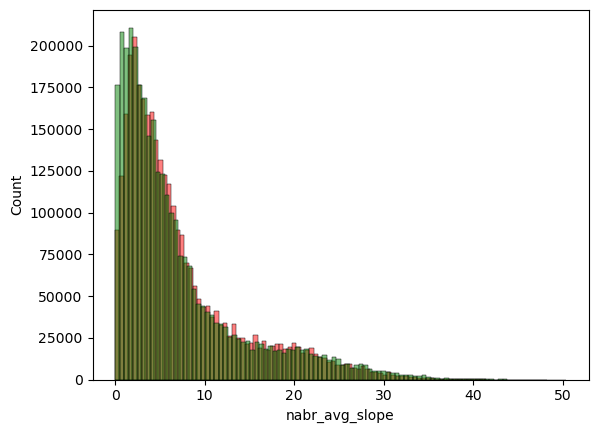

In [3]:
sns.histplot(data = dataset.nabr_avg_slope, bins = 100, alpha = .5, color = 'red')
sns.histplot(data = dataset.nabr_med_slope, bins = 100, alpha = .5, color = 'green')

In [16]:
bin_slope

array([ 1,  2,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 18, 19, 20, 22, 23, 25, 27, 29, 31, 35, 40])

In [13]:
import mapclassify as mc
n = 30
bin_slope = mc.NaturalBreaks(dataset['avg_slope'].sample(10000).dropna(), k = n).bins.round().astype('int')
bin_count = mc.Quantiles(dataset['num_nabr'].sample(10000).dropna(), k = n).bins.round().astype('int')


In [14]:
dataset['slope_bin'] = pd.cut(dataset['avg_slope'], bins=bin_slope)
dataset['bdensity_bin'] = pd.cut(dataset['num_nabr'], bins=bin_count)

dataset['slope_bin'] = dataset['slope_bin'].cat.rename_categories(dict(zip(dataset['slope_bin'].cat.categories,r_slope)))
dataset['bdensity_bin'] = dataset['bdensity_bin'].cat.rename_categories(dict(zip(dataset['bdensity_bin'].cat.categories,r_bldg)))

ValueError: Bin edges must be unique: array([ 1,  2,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 18, 19, 20, 22, 23, 25, 27, 29, 31, 35, 40]).
You can drop duplicate edges by setting the 'duplicates' kwarg

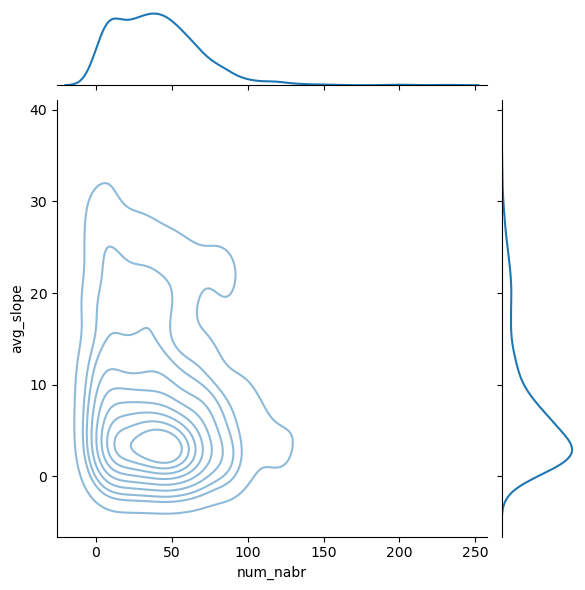

In [8]:
sns.jointplot(data=dataset.sample(1000), x="num_nabr", y="avg_slope", alpha = .5, kind='kde')

# plt.yscale('log'), plt.xscale('log')

In [ ]:
X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].mean().unstack()
sns.heatmap(x, ax=ax,cmap = cmap, square = True, linewidths=0, alpha = alpha, cbar = False)

In [2]:
gdf_hexbin = pd.read_pickle('../../../geodata/results/04_vm_hexbin.pkl')
gdf_commune = pd.read_pickle('../../../geodata/results/04_vm_commune.pkl')

In [24]:
def binfeat(x, n):
    bin_me = mc.NaturalBreaks(x.dropna(), k = n).bins.round().astype('int')
    return pd.cut(x, bins = bin_me, include_lowest = True)

gdf_hexbin['slope_bin'] = binfeat(gdf_hexbin.slope_median, 25)
gdf_hexbin['bdensity_bin'] = binfeat(gdf_hexbin['count'], 25)
gdf_hexbin['avg_bin'] = binfeat(gdf_hexbin.avg, 10)

r_bldg = gdf_hexbin['bdensity_bin'].cat.categories.right.map(int).astype(str)
r_slope = gdf_hexbin['slope_bin'].cat.categories.right.map(int).astype(str)

In [33]:
def binfeat(x, n):
    bin_me = mc.Quantiles(x.dropna(), k = n).bins
    return pd.cut(x, bins = bin_me)

gdf_hexbin['slope_bin'] = binfeat(gdf_hexbin.slope_mean, 25)
gdf_hexbin['bdensity_bin'] = binfeat(gdf_hexbin['count'], 25)
gdf_hexbin['avg_bin'] = binfeat(gdf_hexbin.avg, 10)

<Axes: xlabel='bdensity_bin', ylabel='slope_bin'>

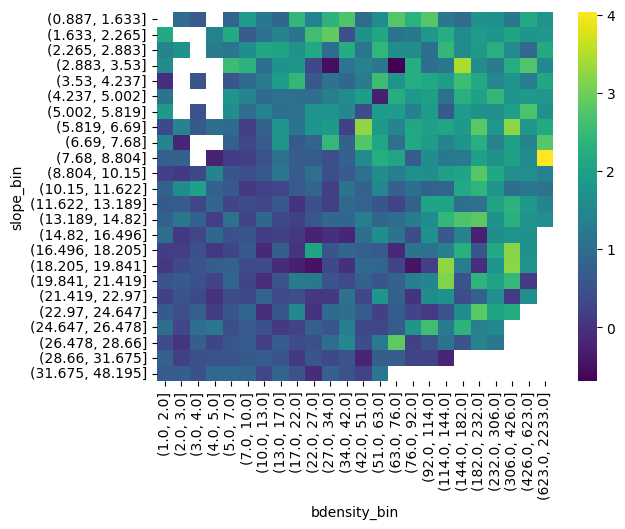

In [42]:
Xcount = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['avg'].count().unstack()
X = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['avg'].skew().unstack()

X = X[Xcount > 10]

sns.heatmap(X, cmap = 'viridis')

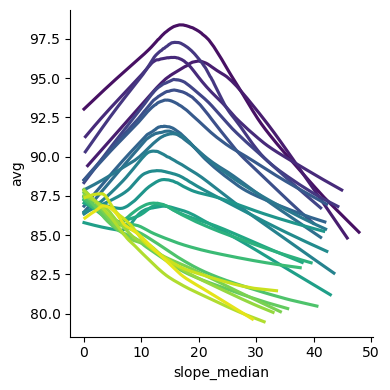

In [38]:
sns.lmplot(data = gdf_hexbin.dropna(), 
            x = 'slope_median', y = 'avg', hue ='bdensity_bin' , 
            scatter = False, lowess = True, palette = 'viridis', ci = .95, height = 4, legend = False)


Text(1044.6767676767674, 0.5, 'Building Density')

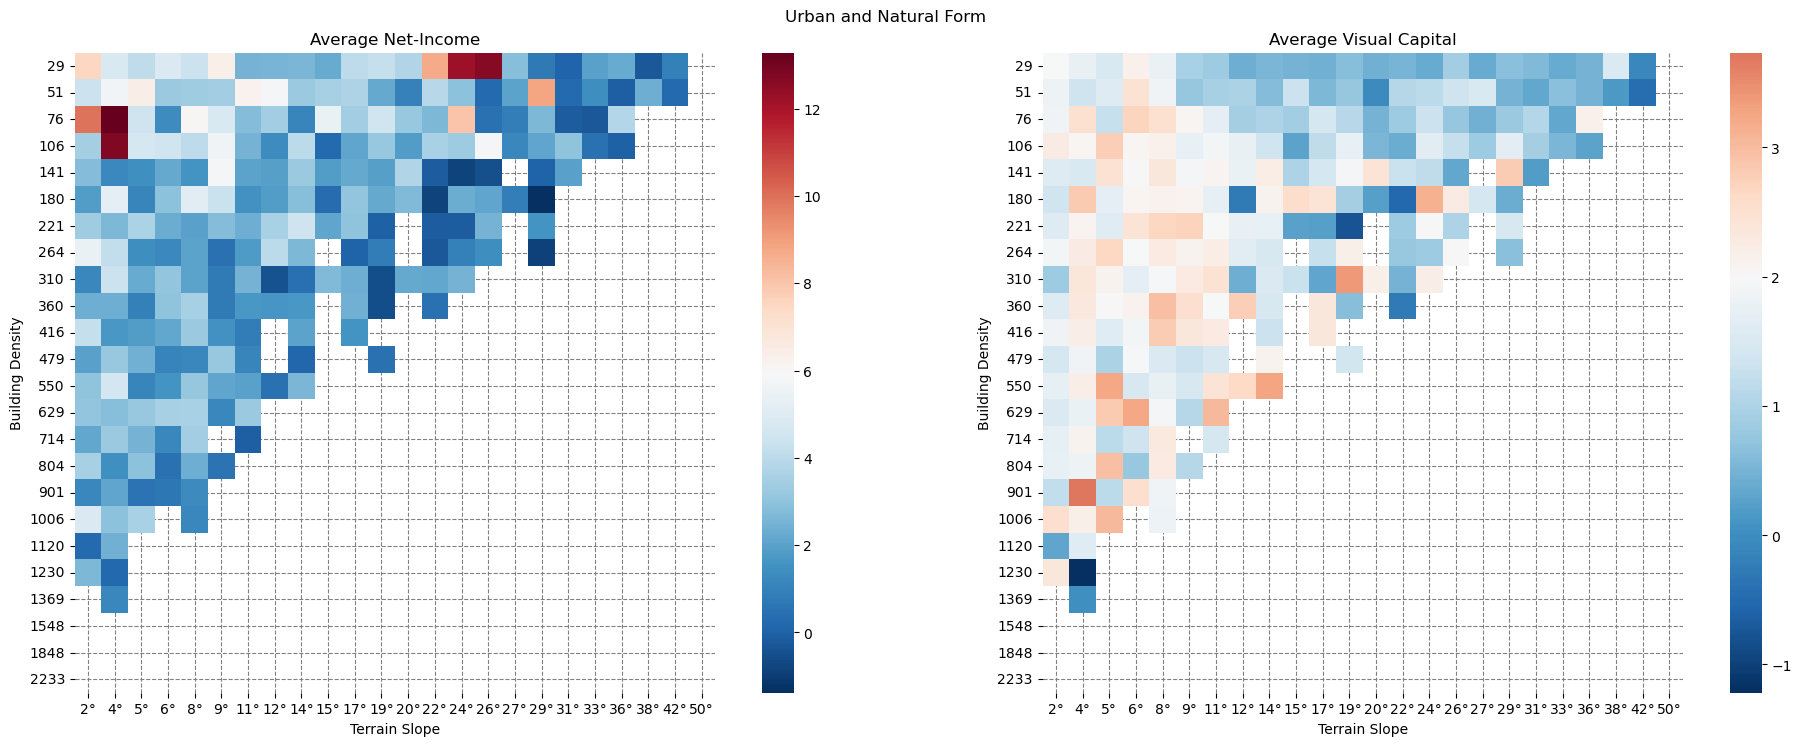

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7.5), sharex=True, sharey=False)
Xcount = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['avg'].count().unstack()
X_vc = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['med'].skew().unstack()
X_income = gdf_hexbin.groupby(['slope_bin','bdensity_bin'])['net_income_ptp'].skew().unstack()

thr = 10

# sns.heatmap(X_income[Xcount <= thr].T, ax=ax1,cmap = 'Greys', square = True, linewidths=0, alpha = .5)
sns.heatmap(X_income[Xcount > thr].T, ax=ax1,cmap = 'RdBu_r', square = True, linewidths=0)

# sns.heatmap(X_vc[Xcount <= thr].T, ax=ax2,cmap = 'Greys', square = True, linewidths=0, alpha = .5)
sns.heatmap(X_vc[Xcount > thr].T, ax=ax2,cmap = 'RdBu_r', center = 2, square = True, linewidths=0)

ax1.set_title('Average Net-Income')
ax2.set_title('Average Visual Capital')

ax1.set_yticklabels(r_bldg,  rotation = 0)
ax1.set_xticklabels(r_slope+u'\N{DEGREE SIGN}', rotation = 0)

ax2.set_yticklabels(r_bldg, rotation = 0)
ax2.set_xticklabels(r_slope+u'\N{DEGREE SIGN}', rotation = 0)

plt.suptitle('Urban and Natural Form')
plt.tight_layout()

ax1.set_axisbelow(True)
ax1.xaxis.grid(color='gray', linestyle='dashed')
ax1.yaxis.grid(color='gray', linestyle='dashed')

ax2.set_axisbelow(True)
ax2.xaxis.grid(color='gray', linestyle='dashed')
ax2.yaxis.grid(color='gray', linestyle='dashed')

ax1.set_xlabel('Terrain Slope')
ax1.set_ylabel('Building Density')

ax2.set_xlabel('Terrain Slope')
ax2.set_ylabel('Building Density')